In [1]:

!pip install --quiet pyarrow
!pip install pandas Pillow kagglehub ipywidgets numpy matplotlib pyarrow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
import random
import tensorflow as tf

In [3]:
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_parquet("/content/drive/MyDrive/MRI Dataset/train.parquet")
test_df = pd.read_parquet("/content/drive/MyDrive/MRI Dataset/test.parquet")

Mounted at /content/drive


In [5]:
def bytes_to_pixels(b: bytes) -> np.ndarray:
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values (grayscale).
    """
    img = Image.open(io.BytesIO(b))  # convert to grayscale
    return np.array(img)
def extract_bytes(blob):
    """
    Unwrap a dict‐wrapped binary payload if needed,
    otherwise return blob directly.
    """
    if isinstance(blob, dict):
        # try common keys
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        # fallback: first bytes‐like value
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
test_df["image"]  = test_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))

1. label = 2, size =  (128, 128)


/tmp/ipython-input-1878512772.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixels.astype("uint8"), mode="L")


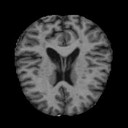

2. label = 0, size =  (128, 128)


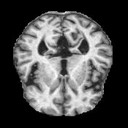

3. label = 3, size =  (128, 128)


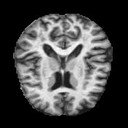

4. label = 3, size =  (128, 128)


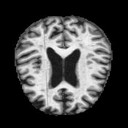

5. label = 2, size =  (128, 128)


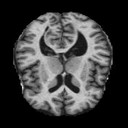

6. label = 2, size =  (128, 128)


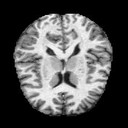

7. label = 2, size =  (128, 128)


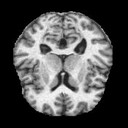

8. label = 2, size =  (128, 128)


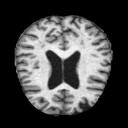

9. label = 3, size =  (128, 128)


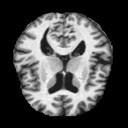

10. label = 2, size =  (128, 128)


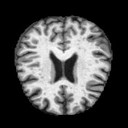

11. label = 2, size =  (128, 128)


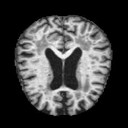

12. label = 1, size =  (128, 128)


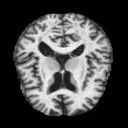

13. label = 2, size =  (128, 128)


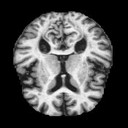

14. label = 3, size =  (128, 128)


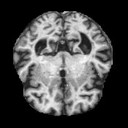

15. label = 2, size =  (128, 128)


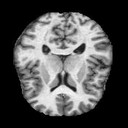

16. label = 3, size =  (128, 128)


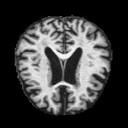

17. label = 3, size =  (128, 128)


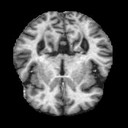

18. label = 0, size =  (128, 128)


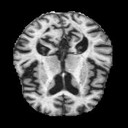

19. label = 3, size =  (128, 128)


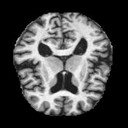

20. label = 2, size =  (128, 128)


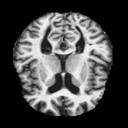

In [6]:
def display_images(df, n=20):
    """
    Display the first n grayscale images (numpy arrays) from df
    along with their labels. Assumes df has columns 'image' and 'label'.
    """
    for i, (_, row) in enumerate(df.head(n).iterrows(), start=1):
        pixels = row["image"]
        label = row.get("label", "")
        # Create a PIL image in 'L' mode (8-bit pixels, black and white)
        img = Image.fromarray(pixels.astype("uint8"), mode="L")
        print(f"{i}. label = {label}, size =  {img.size}")
        display(img)
display_images(train_df)

# Exploratory Data Analysis(EDA)

In [57]:
train_df.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2


In [61]:
print(f"Dataset Shape --> {train_df.shape}")
train_df.info()

Dataset Shape --> (5120, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5120 non-null   object
 1   label   5120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.1+ KB


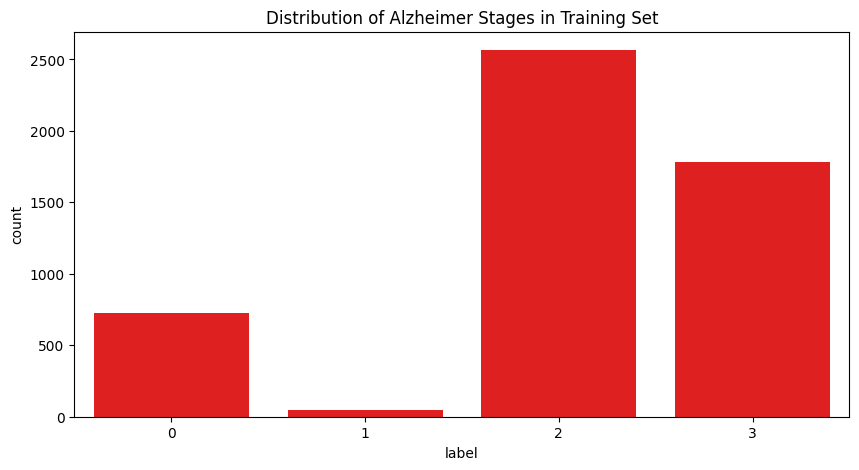

In [34]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='label', color="red")
plt.title('Distribution of Alzheimer Stages in Training Set')
plt.show()

Text(0.5, 0, 'label')

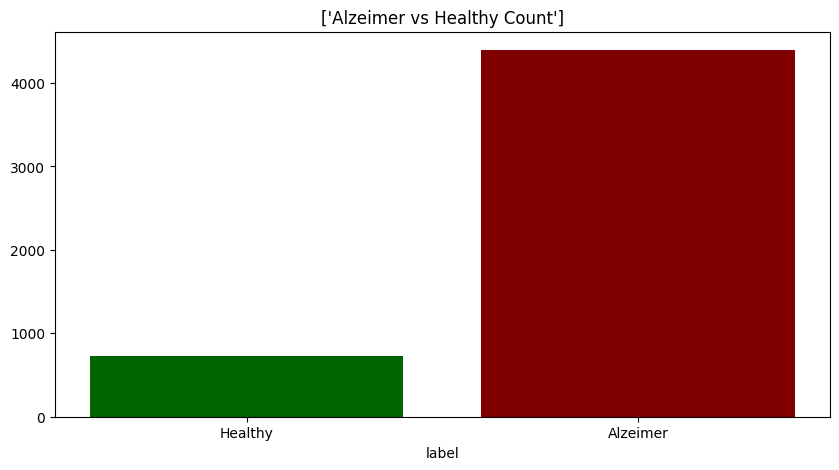

In [40]:
healthy = len(train_df[train_df["label"] == 0])
Alzeimer = len(train_df[train_df["label"] != 0])

plt.figure(figsize=(10,5))
plt.bar(["Healthy","Alzeimer"],[healthy, Alzeimer],color=["darkgreen","maroon"])
plt.title(["Alzeimer vs Healthy Count"])
plt.xlabel("label")

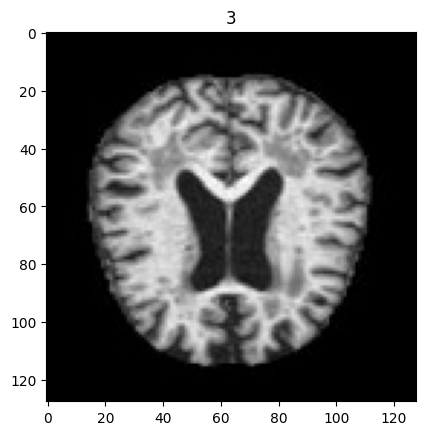

In [47]:
plt.imshow(pixels.squeeze(), cmap="gray")
plt.title(train_df.loc[105, "label"])
plt.show()

In [8]:
X_train = np.array(train_df["image"].tolist()) / 255.0
X_test = np.array(test_df["image"].tolist()) / 255.0

X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_test  = np.repeat(X_test[..., np.newaxis], 3, axis=-1)


In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

y_train = train_df["label"]
y_test  = test_df["label"]

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Transfer learning

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19

In [11]:
conv_base = VGG19(
    weights = "imagenet",
    include_top = False,
    input_shape = (128, 128, 3)

)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:

conv_base.trainable = False

model = Sequential()

model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y_train)), activation = "softmax"))

In [14]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [15]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
import numpy as np

classes, counts = np.unique(y_train, return_counts=True)

for c, cnt in zip(classes, counts):
    print(f"Class {c}: {cnt} images")

Class 0: 588 images
Class 1: 44 images
Class 2: 2033 images
Class 3: 1431 images


In [19]:
import numpy as np

classes, counts = np.unique(y_train, return_counts=True)

for c, cnt in zip(classes, counts):
    print(f"Class {c}: {cnt} images")


Class 0: 588 images
Class 1: 44 images
Class 2: 2033 images
Class 3: 1431 images


In [20]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step - loss: 1.0851 - sparse_categorical_accuracy: 0.4840 - val_loss: 0.8442 - val_sparse_categorical_accuracy: 0.5586
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 0.8956 - sparse_categorical_accuracy: 0.5646 - val_loss: 0.8201 - val_sparse_categorical_accuracy: 0.6289
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 0.7639 - sparse_categorical_accuracy: 0.6471 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.6641
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 0.6403 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.6240 - val_sparse_categorical_accuracy: 0.7100
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - loss: 0.4520 - sparse_categorical_accuracy: 0.8160 - val_loss: 0.6434 - val_sparse_categorical_accuracy: 0.7539
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - loss: 0.3513 - sparse_categorical_accuracy: 0.8608 - val_loss: 0.6676 - val_sparse_categorical_acc

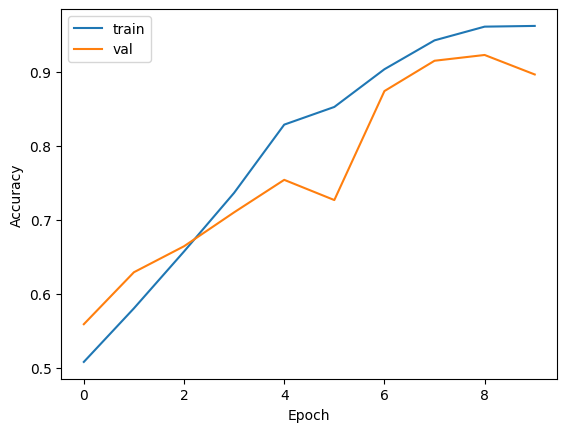

In [21]:
from matplotlib import pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

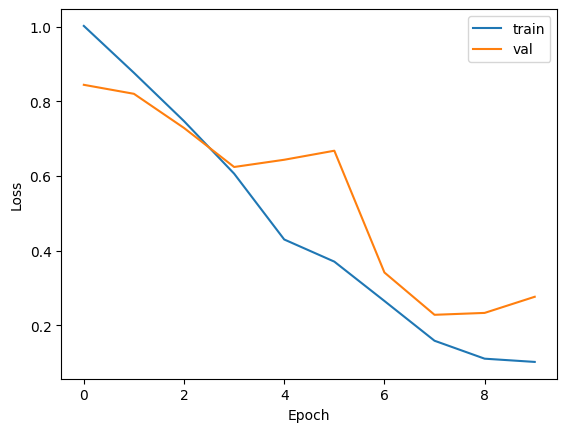

In [63]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.4342 - sparse_categorical_accuracy: 0.8666
Test accuracy: 0.875


In [23]:
from sklearn.metrics import confusion_matrix , classification_report

In [24]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


In [25]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=None))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87       172
           1       0.76      0.87      0.81        15
           2       0.83      0.98      0.90       634
           3       0.93      0.76      0.84       459

    accuracy                           0.88      1280
   macro avg       0.88      0.85      0.86      1280
weighted avg       0.89      0.88      0.87      1280



In [26]:
model.save("alzheimer_cnn_model.keras")


In [27]:
from sklearn.metrics import confusion_matrix

conf_matr = confusion_matrix(y_test, y_pred)
print(conf_matr)

[[135   3  20  14]
 [  0  13   0   2]
 [  0   1 622  11]
 [  2   0 107 350]]


<Axes: >

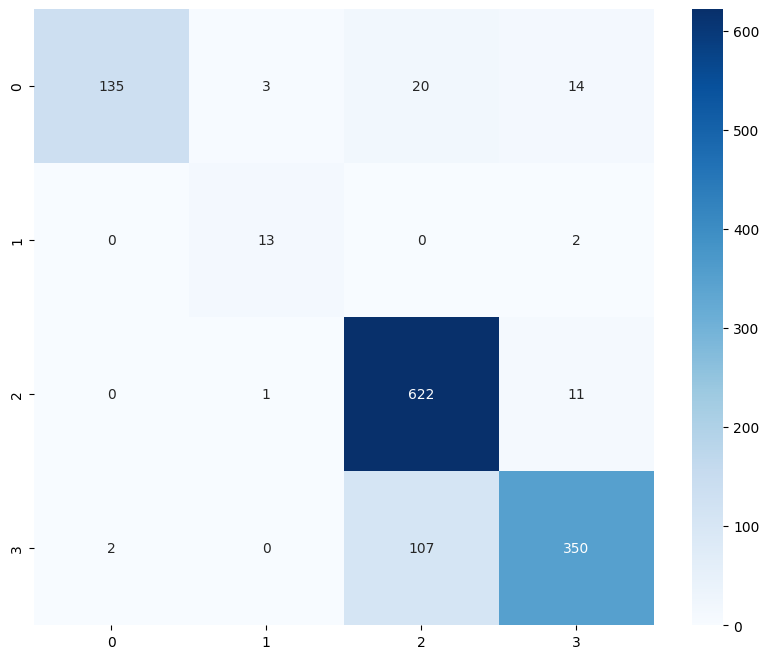

In [28]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matr, annot=True, fmt='d', cmap="Blues")